In [8]:
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

(train_ds, test_ds), ds_info = tfds.load('mnist', split=['train', 'test'], as_supervised=True, with_info=True)
print(ds_info)
# print("train size: ", len(list(train_ds)))
# print("test size: ", len(list(test_ds)))
# What range are pixel values in?
print("pixel value range: ", train_ds.element_spec[0].dtype.min, train_ds.element_spec[0].dtype.max)

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_dir='/home/marvin/tensorflow_datasets/mnist/3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)
pixel v

## How many training/test images are there?
there are 60.000 training images and 10.000 test images

## What’s the image shape?
the image shape is (28,28,1)

## What range are pixel values in?
bwtween 0 and 255

In [9]:
#tfds.show_examples(train_ds, ds_info)

In [10]:
# setting up the data pipeline
def data_pipeline(data, batch_size=32, shuffle_buffer=1000, prefetch_buffer=10):
    data = data.map(lambda image, lable: ((tf.reshape(image, [-1]), lable)))
    data = data.map(lambda image, lable: (((tf.cast(image, tf.float32)/128)-1, lable)))
    data = data.map(lambda image, lable: ((image, tf.one_hot(lable, 10))))
    data = data.shuffle(shuffle_buffer)
    data = data.batch(batch_size)
    data = data.prefetch(prefetch_buffer)
    return data

In [11]:
# Building a deep neural network with TensorFlow
class MLP_Model(tf.keras.layers.Layer):
    def __init__(self, layer_sizes, output_size=10, activation=tf.nn.relu, output_activation=tf.nn.softmax):
        super(MLP_Model, self).__init__()
        self.mlp_layers = []
        for layer_size in layer_sizes:
            new_layer = tf.keras.layers.Dense(layer_size, activation=activation)
            self.mlp_layers.append(new_layer)
        self.output_layer = tf.keras.layers.Dense(output_size, activation=output_activation)

    def call(self, inputs):
        x = inputs
        for layer in self.mlp_layers:
            x = layer(x)
        output = self.output_layer(x)
        return output
        

In [12]:
import numpy as np
def test_mlp(model, test_data, loss_fn):
    test_accuracy_aggregator = []
    test_loss_aggregator = []
    for (inputs, targets) in test_data:
        predictions = model(inputs)
        loss  = loss_fn(targets, predictions)
        test_loss_aggregator.append(loss.numpy())
        acc = np.argmax(targets, axis=1) == np.argmax(predictions, axis=1)
        test_accuracy_aggregator.append(np.mean(acc))
    test_accuracy = np.mean(test_accuracy_aggregator)
    test_loss = np.mean(test_loss_aggregator)
    return test_loss, test_accuracy

# Optimizing the code
def test_mlp_optimized(model, test_data, loss_fn):
    # Determine the number of batches to preallocate the NumPy arrays
    num_batches = tf.data.experimental.cardinality(test_data).numpy()
    batch_losses = np.zeros(num_batches)
    batch_accuracies = np.zeros(num_batches)

    for batch_index, (inputs, targets) in enumerate(test_data):
        predictions = model(inputs)
        loss = loss_fn(targets, predictions)
        batch_losses[batch_index] = loss.numpy()
        acc = np.argmax(targets, axis=1) == np.argmax(predictions, axis=1)
        batch_accuracies[batch_index] = np.mean(acc)
    
    test_accuracy = np.mean(batch_accuracies)
    test_loss = np.mean(batch_losses)
    return test_loss, test_accuracy



# Training the model
def train_model(model, train_data, test_data, loss_fn, optimizer, epochs=5):
    # Initialize lists for later visualization.
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []
    # testing once before we begin
    test_loss, test_acc = test_mlp(model, test_data, loss_fn)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)
    train_loss, train_acc = test_mlp(model, train_data, loss_fn)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    

    for epoch in range(epochs):
        for inputs, targets in train_data:
            with tf.GradientTape() as tape:
                pred = model(inputs)
                loss = loss_fn(targets, pred)
            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        train_loss, train_acc = test_mlp(model, train_data, loss_fn)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        test_loss, test_acc = test_mlp(model, test_data, loss_fn)
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)
        print("Epoch: {}, Loss: {}".format(epoch+1, train_losses[-1]))

    return train_losses, train_accuracies, test_losses, test_accuracies


def train_model_optimized(model, train_data, test_data, loss_fn, optimizer, epochs=5):
    # Preallocate arrays with an extra slot for the initial untrained model metrics
    train_losses = np.zeros(epochs + 1)
    train_accuracies = np.zeros(epochs + 1)
    test_losses = np.zeros(epochs + 1)
    test_accuracies = np.zeros(epochs + 1)

    # Evaluate the untrained model on both the training and test data
    initial_train_loss, initial_train_accuracy = test_mlp_optimized(model, train_data, loss_fn)
    initial_test_loss, initial_test_accuracy = test_mlp_optimized(model, test_data, loss_fn)

    train_losses[0] = initial_train_loss
    train_accuracies[0] = initial_train_accuracy
    test_losses[0] = initial_test_loss
    test_accuracies[0] = initial_test_accuracy

    # Loop over epochs
    for epoch in range(epochs):
        # Lists to hold metrics for each batch
        batch_losses = []
        batch_accuracies = []

        # Loop over each batch of data
        for inputs, targets in train_data:
            with tf.GradientTape() as tape:
                predictions = model(inputs)
                loss = loss_fn(targets, predictions)
            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

            # Record the loss and accuracy
            batch_losses.append(loss.numpy())
            batch_accuracies.append(np.mean(np.argmax(targets, axis=1) == np.argmax(predictions, axis=1)))

        # Record the mean loss and accuracy for the epoch
        train_losses[epoch + 1] = np.mean(batch_losses)
        train_accuracies[epoch + 1] = np.mean(batch_accuracies)

        # Evaluate on test data
        test_loss, test_acc = test_mlp_optimized(model, test_data, loss_fn)
        test_losses[epoch + 1] = test_loss
        test_accuracies[epoch + 1] = test_acc

        print(f"Epoch: {epoch + 1}, Training Loss: {train_losses[epoch + 1]:.4f}, Training Accuracy: {train_accuracies[epoch + 1]:.4f}, Test Loss: {test_losses[epoch + 1]:.4f}, Test Accuracy: {test_accuracies[epoch + 1]:.4f}")

    return train_losses, train_accuracies, test_losses, test_accuracies




In [16]:
# Training the model
EPOCHS = 100
LEARNING_RATE = 0.1
loss_fn = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.legacy.SGD(LEARNING_RATE)
batch_size = 32
train_data = data_pipeline(train_ds, batch_size=batch_size)
test_data = data_pipeline(test_ds, batch_size=batch_size)
LAYERS = [32]
model = MLP_Model(LAYERS)
train_losses, train_accuracies, test_losses, test_accuracies = train_model_optimized(model, train_data, test_data, loss_fn, optimizer, EPOCHS) # without optimized code 12m27s mit 7m9s

Epoch: 1, Training Loss: 0.6520, Training Accuracy: 0.7902, Test Loss: 0.3332, Test Accuracy: 0.9030
Epoch: 2, Training Loss: 0.3862, Training Accuracy: 0.8864, Test Loss: 0.3456, Test Accuracy: 0.8979
Epoch: 3, Training Loss: 0.3460, Training Accuracy: 0.8988, Test Loss: 0.4125, Test Accuracy: 0.8842
Epoch: 4, Training Loss: 0.3242, Training Accuracy: 0.9051, Test Loss: 0.3113, Test Accuracy: 0.9071
Epoch: 5, Training Loss: 0.3061, Training Accuracy: 0.9109, Test Loss: 0.3344, Test Accuracy: 0.9049
Epoch: 6, Training Loss: 0.2753, Training Accuracy: 0.9204, Test Loss: 0.2254, Test Accuracy: 0.9316
Epoch: 7, Training Loss: 0.2596, Training Accuracy: 0.9235, Test Loss: 0.2402, Test Accuracy: 0.9272
Epoch: 8, Training Loss: 0.2499, Training Accuracy: 0.9278, Test Loss: 0.2522, Test Accuracy: 0.9259
Epoch: 9, Training Loss: 0.2431, Training Accuracy: 0.9292, Test Loss: 0.2746, Test Accuracy: 0.9200
Epoch: 10, Training Loss: 0.2357, Training Accuracy: 0.9300, Test Loss: 0.2494, Test Accura

In [14]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

def plot_metrics(train_losses, train_accuracies, test_losses, test_accuracies, loss_fn_name, optimizer_name, learning_rate, layers):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 6))

    # Plot training loss and accuracy
    plt.plot(epochs, train_losses, 'b-', label='Training Loss')
    plt.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')

    # Plot test loss and accuracy
    plt.plot(epochs, test_losses, 'r--', label='Test Loss', alpha=0.7)
    plt.plot(epochs, test_accuracies, 'r--', label='Test Accuracy', alpha=0.7)

    # Annotate the last data points with offsets for clarity
    def annotate_last_point(x, y, text, color, offset_x, offset_y):
        plt.text(x + offset_x, y + offset_y, f'{text}', fontsize=10, color=color,
                 ha='center', va='center', bbox=dict(facecolor='white', edgecolor=color, boxstyle='round,pad=0.5', alpha=0.5))

    # Adding annotations for each metric with manual adjustments to avoid overlap
    y_off_acc = 0.1 if train_accuracies[-1] < test_accuracies[-1] else -0.1
    y_off_loss = 0.1 if train_losses[-1] < test_losses[-1] else -0.1
    annotate_last_point(epochs[-1], train_losses[-1], f'{train_losses[-1]:.4f}', 'blue', 0.4, -y_off_loss)
    annotate_last_point(epochs[-1], train_accuracies[-1], f'{train_accuracies[-1]:.4f}', 'blue', 0.4, -y_off_acc)
    annotate_last_point(epochs[-1], test_losses[-1], f'{test_losses[-1]:.4f}', 'red', 0.4, y_off_loss)
    annotate_last_point(epochs[-1], test_accuracies[-1], f'{test_accuracies[-1]:.4f}', 'red', 0.4, y_off_acc)

    # Title and labels
    plt.title(f'Training & Test Metrics - {loss_fn_name}, {optimizer_name} (LR: {learning_rate}), Hiddenlayers: {layers}', fontsize=16)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss / Accuracy', fontsize=14)
    plt.legend(loc='best', frameon=True)
    plt.grid(True, which='major', linestyle='--', linewidth='0.5', color='grey')
    plt.minorticks_on()

    plt.tight_layout()
    plt.show()



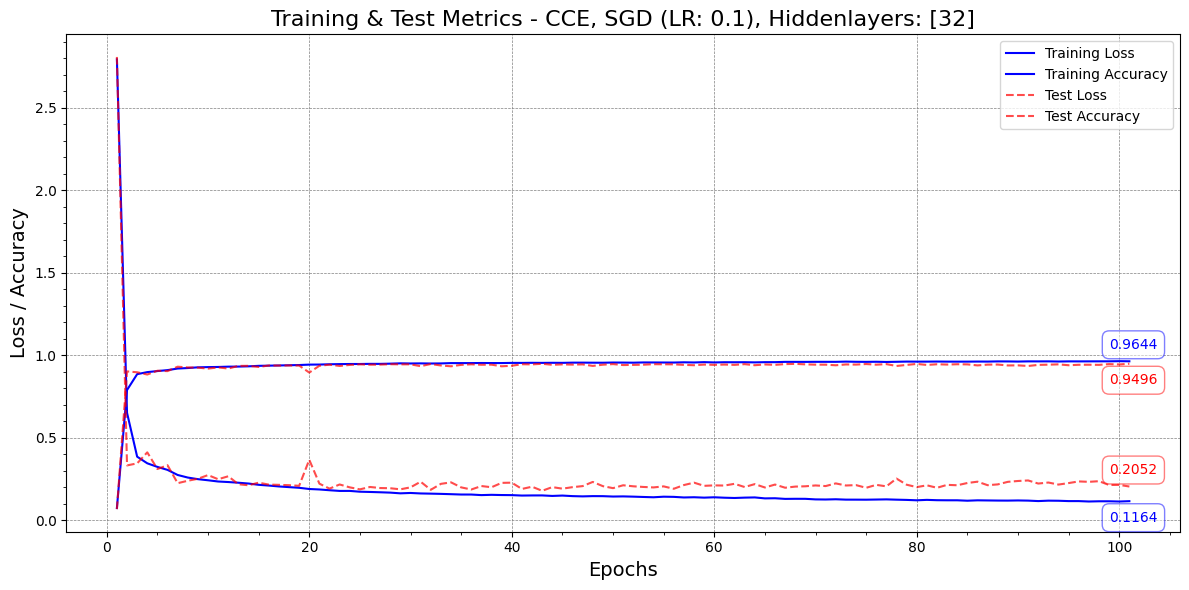

In [17]:
plot_metrics(
    train_losses, 
    train_accuracies, 
    test_losses, 
    test_accuracies, 
    loss_fn_name='CCE', 
    optimizer_name='SGD', 
    learning_rate=LEARNING_RATE,
    layers=LAYERS
)

<table>
<tr>
<td><img src="lr01_256_256.png" style="width:100%"/></td>
<td><img src="lr001_256_256.png" style="width:100%"/></td>
<td><img src="lr01_265.png" style="width:100%"/></td>
</tr>
<tr>
<td><img src="lr01_32.png" style="width:100%"/></td>
<td><img src="lr005_32.png" style="width:100%"/></td>
<td><img src="lr005_16.png" style="width:100%"/></td>
</tr>
<tr>
<td><img src="lr01_32_50.png" style="width:100%"/></td>
<td><img src="lr01_32_100.png" style="width:100%"/></td>
</tr>
</table>
I find it interesting that the task seems so manageable that the outcome does not really change significantly whether one alters the learning rate (LR) to 0.01 or omits an entire layer, provided that the remaining layer is sufficiently large (as seen in the first row).

In the second row, it was still possible to achieve acceptable results (test accuracy of around 95%) with only one layer of 16 perceptrons, which I find quite remarkable. Moreover, it takes a notably longer time—ranging from 50 to 100 epochs—to reach these acceptable performance levels. The model shows rapid improvement in the initial few epochs, but the learning rate slows down considerably with a reduced number of layers.

As observed in the first images of rows 2 and 3, an additional 40 epochs resulted in an improvement of 5%. However, extending the training for 50 more epochs actually led to a slight performance decrement compared to the earlier results. Of course, this observation stems from a single trial; conducting multiple runs would be essential to draw more definitive conclusions.